# MNIST Variational Autoencoder

**Summary:** A notebook of experiments I ran using a simple VAE on the MNIST handwritten digits dataset.
1. Visualizing the VAE Latent Space (stolen from Keras example)
2. Comparing reconstructed images to original images (stolen from Keras example)
3. Generating new images from arbitrary encodings
4. **Animating transition between digits (in the latent vector space)**

### Adapted From:
* [Building Autoencoders in Keras](Building Autoencoders in Keras)
* [Keras Examples: variational_autoencoder.py (Github)](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import losses
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

Using TensorFlow backend.


In [2]:
# Function to add noise to outputted means (re-parameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

## Create VAE Model

In [3]:
# Encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampled z (latent vector), with noise
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [4]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space (without noise)
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [5]:
# Reconstruction error + KL divergence
def vae_loss(x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)

## Train VAE

In [6]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=0)

## Experiment 1: Visualize Latent Space

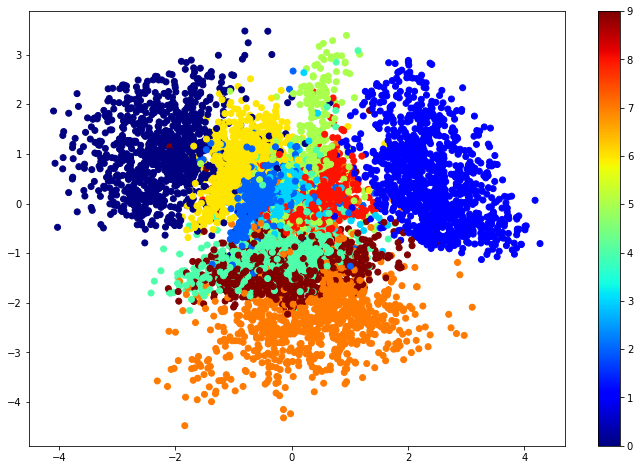

In [134]:
%matplotlib inline
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.jet()
plt.show()

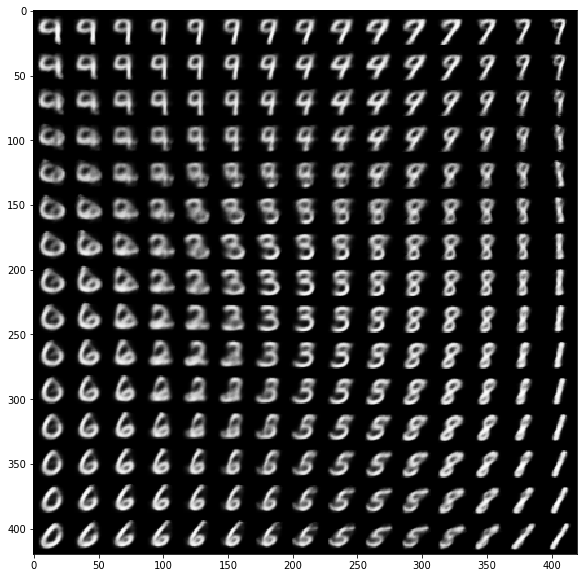

In [135]:
%matplotlib inline
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Experiment 2: Compare Reconstructions to Originals

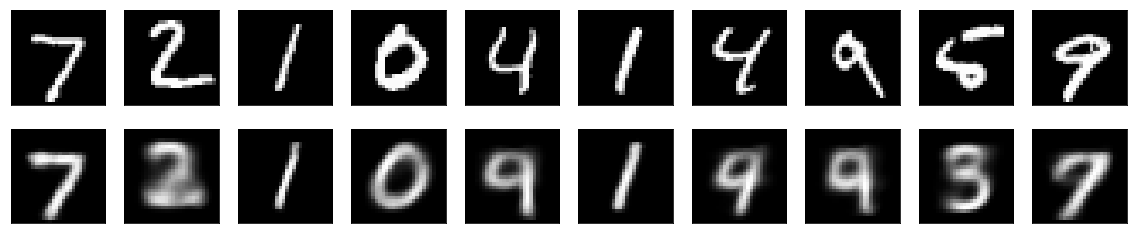

In [136]:
%matplotlib inline
encodings = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Experiment 3: Generate Images from Arbitrary Encoding

In [11]:
print("Minimum encoding value: ", encodings.min())
print("Maximum encoding value: ", encodings.max())
print("Mean encoding value: ", encodings.mean())

Minimum encoding value:  -4.47387
Maximum encoding value:  4.27103
Mean encoding value:  -0.074033


In [137]:
# Display image of reconstructed encoding vector
def generate(encoding):
    reconstructed = generator.predict(np.array([encoding]))[0]
    img = reconstructed.reshape([28, 28])
    plt.gray()
    plt.imshow(img)
    plt.show()

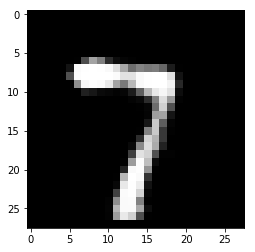

In [138]:
# Play around with different encodings!
%matplotlib inline
generate([3, -5])

## Experiment 4: Animate Transition Between Digits

In [162]:
# Get mean encoding of a certain digit
def mean_encoding(digit):
    if digit < 0 or digit > 9: 
        print("ERROR: Invalid digit!")
        return np.array([0, 0])
    
    digit_indices = np.where(y_train == digit) # indices of given digit
    digit_samples = x_train[digit_indices] # retrieve images
    encodings = encoder.predict(digit_samples) # encode images
    mean_encoding = np.mean(encodings, axis=0) # average over encodings
    
    return mean_encoding

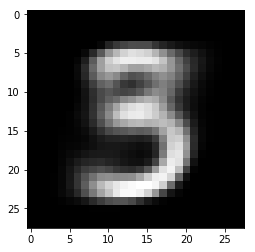

In [163]:
# Make sure that we can reproduce the mean_encoding vector
%matplotlib inline
generate(mean_encoding(3)) # Test out values between 0-9

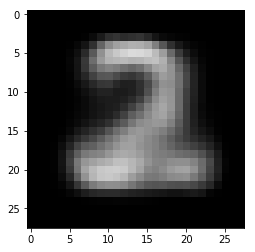

In [180]:
### ---------- DIGIT TRANSITION ANIMATOR ---------- ###

# IMPORTS
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

# SETTINGS
DIGIT1 = 0 # "from" digit
DIGIT2 = 2 # "to" digit

ITERATIONS = 100 # number of frames


# INITIALIZATIONS
fig = plt.figure()

# Encodings & "difference" vector
encoding1 = mean_encoding(DIGIT1)
encoding2 = mean_encoding(DIGIT2)
diff = encoding2 - encoding1

# Iteration trackers
iterations_counter = 0 # track how many iterations
diff_tracker = 0
step = 1./iterations # how much to jump each time

# Initial image: Digit 1
curr_encoding = encoding1
img_array = generator.predict(np.array([curr_encoding]))[0].reshape(28, 28)
im = plt.imshow(img_array, animated=True)

# IMAGE UPDATE PROCEDURE
def updatefig(*args):
    global curr_encoding, iterations_counter, img_array, im
    
    # Iterations_counter has hit limit: reset
    if iterations_counter >= iterations:
        iterations_counter = 0
        curr_encoding = encoding1
    else:
        iterations_counter += 1
        curr_encoding += step * diff
        
    img_array = generator.predict(np.array([curr_encoding]))[0].reshape(28, 28)
    im.set_array(img_array)
    return [im]

# ANIMATE!
ani = animation.FuncAnimation(fig, updatefig, interval=50)
# ani.save('{}-to-{}.gif'.format(DIGIT1, DIGIT2), dpi=80, fps=30, writer='imagemagick')
HTML(ani.to_jshtml())